In [4]:
from huggingface_hub import snapshot_download

# Load datasets
download_path = "/mnt/data0/drs25/data/"
local_dir = snapshot_download(
    repo_id="mburgjr/GelSight-YoungsModulus",  # Hugging Face dataset repo
    repo_type="dataset",
    local_dir=download_path
)
print("Dataset downloaded to:", local_dir)
"""download_path = "/mnt/data0/drs25/data/"
local_dir = snapshot_download(
    repo_id="facebook/gelsight-force-estimation",  # Hugging Face dataset repo
    repo_type="dataset",
    local_dir=download_path
)
print("Dataset downloaded to:", local_dir)
"""
#files will need to be manually unzipped

Fetching 3 files: 100%|██████████| 3/3 [05:53<00:00, 117.69s/it]


Dataset downloaded to: /mnt/data0/drs25/data


Fetching 91 files: 100%|██████████| 91/91 [06:38<00:00,  4.38s/it]

Dataset downloaded to: /mnt/data0/drs25/data


## Inspect and Process data

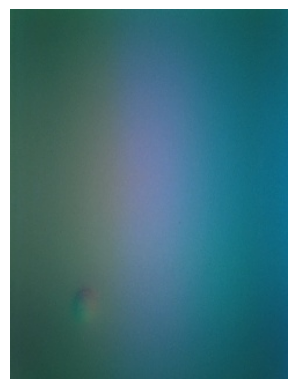

dict_keys(['in_contact', 'trajectories'])


In [99]:
import pickle
import cv2
import numpy as np
import io
import matplotlib.pyplot as plt
def load_pickle_dataset(file_dataset):
    with open(file_dataset, "rb") as f:
        all_frames = pickle.load(f)
    return all_frames

def load_bin_image(io_buf):
    # Convert bytes buffer to a NumPy array
    nparr = np.frombuffer(io_buf, np.uint8)
    # Decode image with OpenCV
    img = cv2.imdecode(nparr, cv2.IMREAD_UNCHANGED)  # keeps original channels
    return img

frames = load_pickle_dataset('/mnt/data0/drs25/data/FORCE/sphere/batch_1/dataset_gelsight_00.pkl')
frames1 = load_pickle_dataset('/mnt/data0/drs25/data/FORCE/sphere/batch_1/dataset_gelsight_01.pkl')
frames2 = load_pickle_dataset('/mnt/data0/drs25/data/FORCE/sphere/batch_1/dataset_gelsight_02.pkl')
frames3 = load_pickle_dataset('/mnt/data0/drs25/data/FORCE/sphere/batch_1/dataset_gelsight_03.pkl')
forces = load_pickle_dataset('/mnt/data0/drs25/data/FORCE/sphere/batch_1/dataset_slip_forces.pkl')
img = load_bin_image(frames[0])
plt.imshow(img)
plt.axis("off")
plt.show()
print(forces.keys())

17288 17288
dict_keys(['indexes', 'forces', 'forces_slip', 'poses', 'delta_forces', 'delta_mag_shear', 'delta_mag_normal', 'slip_label', 'coef_friction'])
23


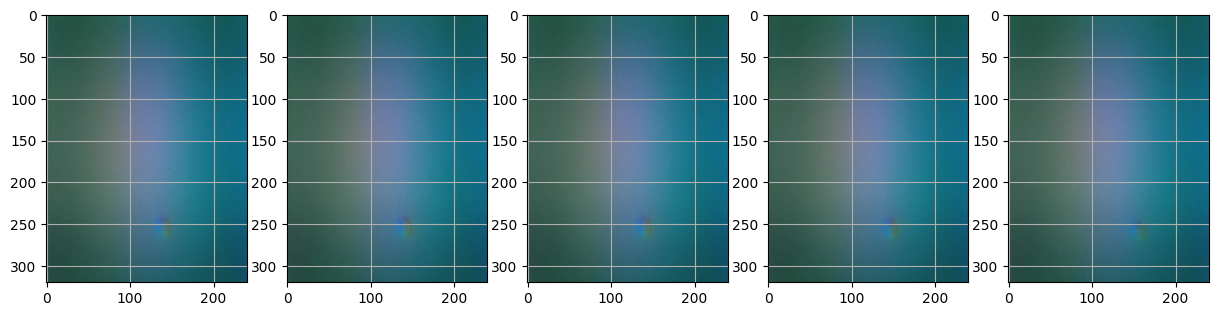

[[-0.00443221 -0.00231041  0.16037084]
 [-0.00479696 -0.00231752  0.16415005]
 [-0.00513948 -0.00239047  0.16759209]
 [-0.00555316 -0.00245987  0.17168356]
 [-0.00594638 -0.00247944  0.17545832]
 [-0.00623107 -0.00250969  0.17807744]
 [-0.00645348 -0.00252748  0.1803398 ]
 [-0.0065976  -0.00249456  0.18148655]
 [-0.00664386 -0.00246076  0.18154171]
 [-0.00500514  0.00342602  0.18141805]
 [-0.00139763  0.03252095  0.18130062]
 [ 0.00318849  0.05784023  0.17978021]
 [ 0.00862065  0.08510249  0.17810946]
 [ 0.01321478  0.11150001  0.17622075]
 [ 0.0155928   0.12676631  0.17118536]
 [ 0.01630184  0.121295    0.16517492]
 [ 0.01587392  0.11696332  0.15883532]
 [ 0.01452166  0.10722171  0.15138277]
 [ 0.01443982  0.10135184  0.14364375]
 [ 0.01428146  0.09882614  0.13718138]
 [ 0.01389713  0.0910115   0.13097344]
 [ 0.01374234  0.08870821  0.12629391]
 [ 0.01294877  0.08706949  0.1206758 ]]


In [133]:
print(len(forces['in_contact']),len(frames)+len(frames1)+len(frames2)+len(frames3))
all_frames = frames + frames1 + frames2 + frames3
print(forces['trajectories'][1].keys())
trajectory = forces['trajectories'][2]
traj_frames = [load_bin_image(all_frames[i]) for i in trajectory['indexes']]
traj_forces = trajectory['forces']
traj_slip = trajectory['slip_label']

assert len(traj_frames) == len(traj_forces) == len(traj_slip)
print(len(traj_frames))
plt.figure(figsize=(15,5))
for i,j in enumerate(range(0,len(traj_frames),4)):
    try:
        plt.subplot(1,len(traj_frames)//4,i+1)
        #plt.axis("off")
        plt.imshow(traj_frames[j])
        plt.grid(True)
    except:
        pass

plt.show()


In [132]:
def loadData(path):
    indexfile=load_pickle_dataset(path+'dataset_slip_forces.pkl')
    other_file = os.listdir(path)
    i=0
    while i <len(other_file):
        if "org" in other_file[i] or "slip" in other_file[i]: 
            other_file.pop(i)
        else:
            i+=1
    #get other files
    images=[]
    for i in range(len(other_file)):
        images+=load_pickle_dataset(path+other_file[i])
    print(len(images))
    temp=[]
    y=[]
    for event in forces['trajectories']:
        trajectory=forces['trajectories'][event]
        traj_forces = trajectory['forces']
        traj_slip = trajectory['slip_label']
        temp.append([load_bin_image(images[i]) for i in trajectory['indexes']])
        y.append()
        print(len(temp[-1]))
    
loadData("/mnt/data0/drs25/data/FORCE/sphere/batch_1/")

17288
41
23
91
55
90
31
55
77
111
104
74
93
28
86
91
45
37
47
69
9
104
121
112
66
124
93
82
104
24
111
124
39
102
63
80
88
97
82
32
91
34
86
98
101
129
56
129
91
31
23
105
126
49
53
53
64
25
24
90
38
28
65
110
118
40
42
26
111
86
104
27
118
111
113
33
6
99
99
88
67
28
75
98
86
99
52
112
58
82
92
47
80
55
93
71
75
32
30
89
93
60
85
6
109
66
96
115
35
25
37
123
61
54
85
6
98
16
66
63
51
104
25
79
110
11
138
101
101
16
22
22
103
120
106
114
18
105
55
127
125
115
101
71
53
44
90
19
49


In [72]:
aligned_data = []
trajectory=forces['trajectories'][1]
for i, frame in enumerate(frames):
    if i < len(trajectory['forces']):
        aligned_data.append({
            'image': frame,
            'force': trajectory['forces'][i],
            'slip': trajectory['slip_label'][i]
        })

trajectory_num = 1  
trajectory = forces['trajectories'][trajectory_num]

traj_forces = trajectory['forces'] 
traj_slip = trajectory['slip_label']
print(len(frames), len(traj_forces), len(traj_slip))
len(frames) % len(traj_forces)

5000 41 41


39

In [23]:
import os
import pickle

def gatherdata(directory):
    X = []
    y = []

    # Loop through each object type folder
    for obj_name in os.listdir(directory):
        obj_path = os.path.join(directory, obj_name)
        if not os.path.isdir(obj_path):
            continue

        # Loop through each batch folder
        for batch in os.listdir(obj_path):
            batch_path = os.path.join(obj_path, batch)
            if not os.path.isdir(batch_path):
                continue

            # Load slip forces file
            slip_forces_path = os.path.join(batch_path, "dataset_slip_forces.pkl")
            if os.path.exists(slip_forces_path):
                with open(slip_forces_path, "rb") as f:
                    slip_forces = pickle.load(f)
            else:
                slip_forces = None

            # Loop through gelsight files
            for file in os.listdir(batch_path):
                if file.startswith("dataset_gelsight") and file.endswith(".pkl"):
                    file_path = os.path.join(batch_path, file)

                    # Append file path to X
                    X.append(file_path)

                    # Build a description string for y
                    # For example: "object: sphere, batch: batch_1, trajectory: 00"
                    trajectory = slip_forces_path['trajectories']#file.split("_")[-1].split(".")[0]  # e.g., "00"
                    contact = slip_forces_path['in_contact']#"in contact" if slip_forces is not None else "no contact"
                    desc = f"object: {obj_name}, trajectory: {trajectory}, {contact}"
                    y.append(desc)

    return X, y

X,y=gatherdata("/mnt/data0/drs25/data/FORCE/")

print(X[0:10])
print(y[0:10])

['/mnt/data0/drs25/data/FORCE/flat/batch_1/dataset_gelsight_03.pkl', '/mnt/data0/drs25/data/FORCE/flat/batch_1/dataset_gelsight_01.pkl', '/mnt/data0/drs25/data/FORCE/flat/batch_1/dataset_gelsight_00.pkl', '/mnt/data0/drs25/data/FORCE/flat/batch_1/dataset_gelsight_02.pkl', '/mnt/data0/drs25/data/FORCE/flat/batch_2/dataset_gelsight_00.pkl', '/mnt/data0/drs25/data/FORCE/flat/batch_2/dataset_gelsight_01.pkl', '/mnt/data0/drs25/data/FORCE/flat/batch_2/dataset_gelsight_02.pkl', '/mnt/data0/drs25/data/FORCE/sharp/batch_1/dataset_gelsight_00.pkl', '/mnt/data0/drs25/data/FORCE/sharp/batch_1/dataset_gelsight_01.pkl', '/mnt/data0/drs25/data/FORCE/sharp/batch_1/dataset_gelsight_02.pkl']
['object: flat, trajectory: 0, 0', 'object: flat, trajectory: 0, 0', 'object: flat, trajectory: 0, 0', 'object: flat, trajectory: 0, 0', 'object: flat, trajectory: 0, 0', 'object: flat, trajectory: 0, 0', 'object: flat, trajectory: 0, 0', 'object: sharp, trajectory: 0, 0', 'object: sharp, trajectory: 0, 0', 'object